In [1]:
!pip install opendatasets --quiet
!pip install contractions --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 13.7 MB/s eta 0:00:00


In [2]:
import opendatasets as od
import numpy as np
import pandas as pd
import re
import seaborn as sns
import contractions
import nltk
nltk.download('all')

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import numpy as np

[nltk_data]    | Downloading package framenet_v17 to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/framenet_v17.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package ieer to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/ieer.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package indian to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/indian.zip.
[nltk_data]    | Downloading package jeita to /root/nltk_data...
[nltk_data]    | Downloading package kimmo to /root/nltk_data...
[nltk_data]   

In [3]:
from nltk.corpus import stopwords

In [4]:
od.download('https://www.kaggle.com/datasets/danofer/sarcasm?datasetId=1309&sortBy=voteCount')

100%|██████████| 216M/216M [00:11<00:00, 19.2MB/s]


In [5]:
df = pd.read_csv("/content/sarcasm/train-balanced-sarcasm.csv")
df

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
...,...,...,...,...,...,...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,TwarkMain,reddit.com,2,2,0,2009-04,2009-04-25 00:47:52,"No one is calling this an engineered pathogen,..."
1010822,1,"whatever you do, don't vote green!",BCHarvey,climate,1,1,0,2009-05,2009-05-14 22:27:40,In a move typical of their recent do-nothing a...
1010823,1,Perhaps this is an atheist conspiracy to make ...,rebelcommander,atheism,1,1,0,2009-01,2009-01-11 00:22:57,Screw the Disabled--I've got to get to Church ...
1010824,1,The Slavs got their own country - it is called...,catsi,worldnews,1,1,0,2009-01,2009-01-23 21:12:49,I've always been unsettled by that. I hear a l...


In [6]:
df.columns

Index(['label', 'comment', 'author', 'subreddit', 'score', 'ups', 'downs',
       'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [7]:
df.isna().sum()

label              0
comment           53
author             0
subreddit          0
score              0
ups                0
downs              0
date               0
created_utc        0
parent_comment     0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.drop(['author', 'subreddit', 'score', 'ups', 'downs','date', 'created_utc', 'parent_comment'],axis=1,inplace=True)

In [10]:
df.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


<Axes: xlabel='label', ylabel='count'>

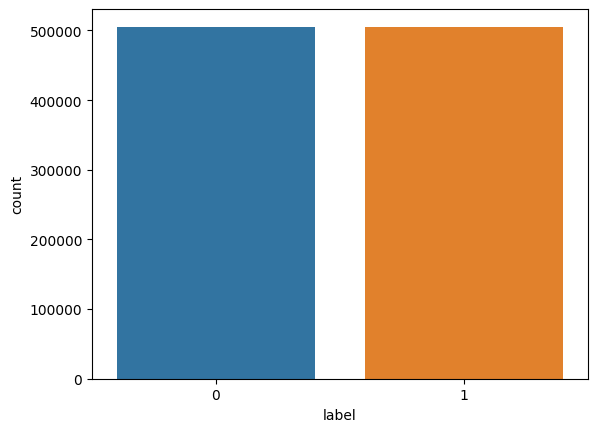

In [11]:
sns.countplot(x=df['label'])

<Axes: ylabel='Frequency'>

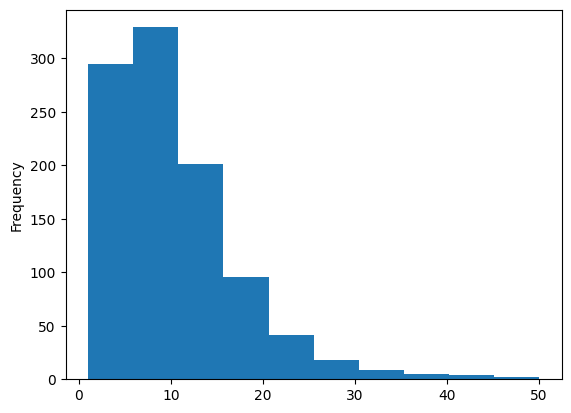

In [12]:
df['comment'].sample(1000).map(lambda x: len(x.split())).plot(kind='hist')

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model

In [14]:
def clean_contraction_mapping(text):
  expanded_words = []
  for word in text.split():
    expanded_words.append(contractions.fix(word))
  expanded_text = ' '.join(expanded_words)
  return expanded_text

In [15]:
def clean(text):
  text=clean_contraction_mapping(text)
  text=re.sub('[^a-zA-Z]'," ",text)
  text=text.lower()
  text=text.split()
  text=[lem.lemmatize(word) for word in text]
  return " ".join(text)

In [16]:
lem=WordNetLemmatizer()

In [17]:
df['cleaned_comment']=(df['comment']).apply(clean)

In [18]:
df['length']=df['cleaned_comment'].apply(lambda x: len(x.split(" ")))

In [19]:
df

,label,comment,cleaned_comment,length
0,0,NC and NH.,nc and nh,3
1,0,You do know west teams play against west teams...,you do know west team play against west team m...,14
2,0,"They were underdogs earlier today, but since G...",they were underdog earlier today but since gro...,19
3,0,"This meme isn't funny none of the ""new york ni...",this meme is not funny none of the new york ni...,13
4,0,I could use one of those tools.,i could use one of those tool,7
...,...,...,...,...
1010821,1,I'm sure that Iran and N. Korea have the techn...,i am sure that iran and n korea have the techn...,19
1010822,1,"whatever you do, don't vote green!",whatever you do do not vote green,7
1010823,1,Perhaps this is an atheist conspiracy to make ...,perhaps this is an atheist conspiracy to make ...,11
1010824,1,The Slavs got their own country - it is called...,the slav got their own country it is called ko...,10


In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_df,val_df=train_test_split(df,test_size=0.2,shuffle=True,random_state=42)

In [23]:
len(train_df),len(val_df)

(808618, 202155)

<Axes: xlabel='label', ylabel='count'>

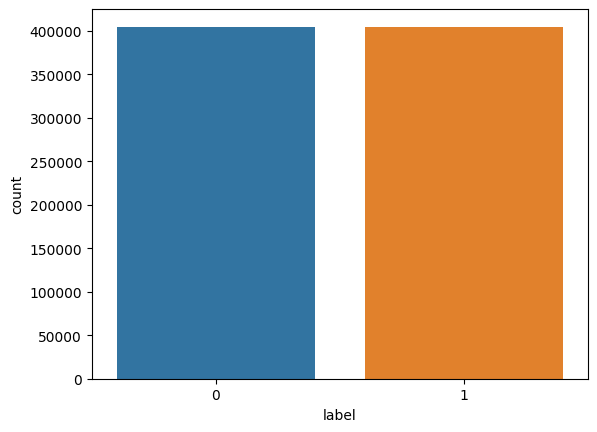

In [24]:
sns.countplot(x=train_df['label'])

<Axes: xlabel='label', ylabel='count'>

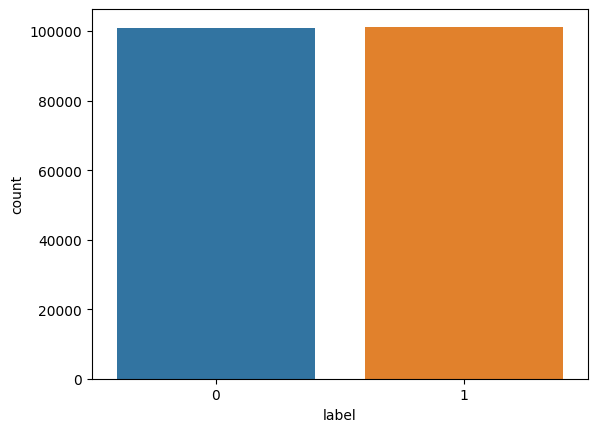

In [25]:
sns.countplot(x=val_df['label'])

In [26]:
train_df.head()

,label,comment,cleaned_comment,length
329453,0,Leo breaking the glass and cutting his hand wa...,leo breaking the glass and cutting his hand wa...,11
923237,0,"I like 11th, it is freaking awesome.",i like th it is freaking awesome,7
780576,1,"You're a robot, you don't have emotions!",you are a robot you do not have emotion,9
956155,1,Everyone knows black people don't have jobs so...,everyone know black people do not have job so ...,13
474410,1,Thank you for that reasoned and well argued co...,thank you for that reasoned and well argued co...,9


## Data is balanced for both train and validation set

In [27]:
tokenizer=Tokenizer()
tokenizer.fit_on_texts(df['cleaned_comment'])
num_words = len(tokenizer.word_index)+1
print("Number of words:", num_words)

Number of words: 145259


In [38]:
VOCAB_SIZE=20000
BATCH_SIZE=256
EMBEDDING_DIM=256
MAX_LENGTH=40
trunc_type='post'
padding_type='post'
oov_token='<OOV>'

In [29]:
from math import trunc
tokenizer=Tokenizer(num_words=VOCAB_SIZE,oov_token=oov_token)
#Training set
tokenizer.fit_on_texts(train_df['cleaned_comment'])
train_sequences = tokenizer.texts_to_sequences(train_df['cleaned_comment'])
train_padded = pad_sequences(train_sequences, maxlen=MAX_LENGTH,padding='post',truncating='post')

# Validation set
val_sequences = tokenizer.texts_to_sequences(val_df['cleaned_comment'])
val_padded = pad_sequences(val_sequences, maxlen=MAX_LENGTH,padding='post',truncating='post')

In [30]:
val_padded.shape,val_df['label'].shape

((202155, 40), (202155,))

In [31]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_padded,train_df['label']))
train_dataset = train_dataset.shuffle(buffer_size=1000)
train_dataset = train_dataset.batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_padded,val_df['label']))
val_dataset = val_dataset.batch(BATCH_SIZE)

In [32]:
for batch in train_dataset:
  print(batch)
  break

(<tf.Tensor: shape=(256, 40), dtype=int32, numpy=
array([[  246,     6,    55, ...,     0,     0,     0],
       [    6,   431,    41, ...,     0,     0,     0],
       [ 1041,  3521,  3557, ...,     0,     0,     0],
       ...,
       [ 1712,  4324,     0, ...,     0,     0,     0],
       [  193, 16206,    47, ...,     0,     0,     0],
       [  202,     2,   224, ...,     0,     0,     0]], dtype=int32)>, <tf.Tensor: shape=(256,), dtype=int64, numpy=
array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = False ,unit_forget_bias=True, implementation=2)),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

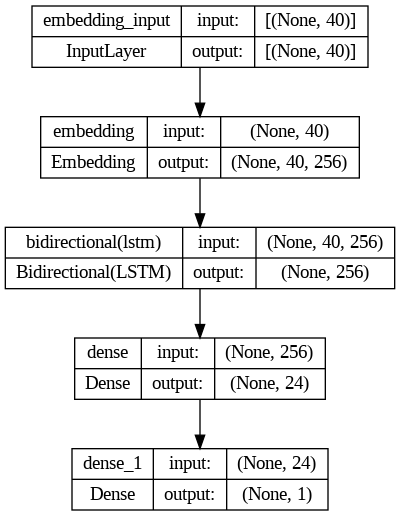

In [34]:
plot_model(model, show_shapes=True)

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 256)           5120000   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              394240    
 l)                                                              
                                                                 
 dense (Dense)               (None, 24)                6168      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 5,520,433
Trainable params: 5,520,433
Non-trainable params: 0
_________________________________________________________________


In [41]:
num_epochs = 2
history = model.fit(train_dataset,epochs=num_epochs,validation_data=val_dataset,verbose=1)

Epoch 1/2
3159/3159 [==============================] - 1267s 401ms/step - loss: 0.5539 - accuracy: 0.7145 - val_loss: 0.5436 - val_accuracy: 0.7211
Epoch 2/2
3159/3159 [==============================] - 1251s 396ms/step - loss: 0.5209 - accuracy: 0.7382 - val_loss: 0.5434 - val_accuracy: 0.7238


In [42]:
model.save_weights('model_weights3.h5')

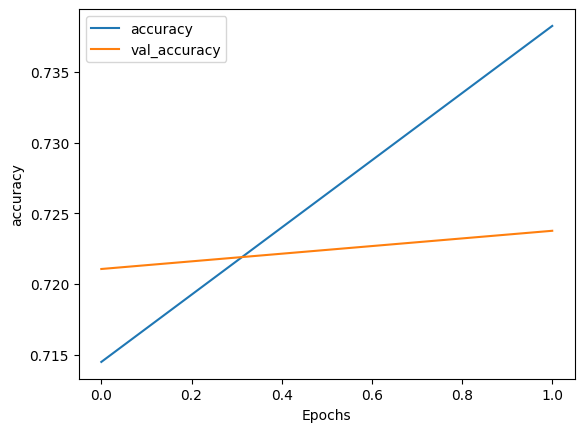

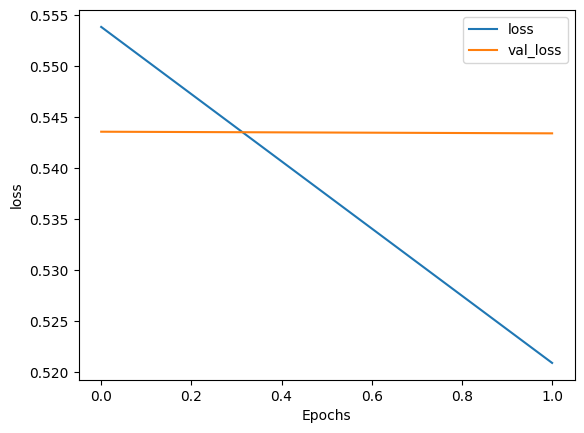

In [43]:
import matplotlib.pyplot as plt
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [56]:
sentence=[df.iloc[44]['comment']]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=MAX_LENGTH, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 67ms/step
[[0.9584736]]


In [57]:
sentence

['wow it is totally unreasonable to assume that the agency that covered up Bush war crimes because "muh republican party" would be partisan as fuck']